- Inputs
    - PSPS Report Processing, Duration of events:  Dec 2020 - Jan 2021
        - 2 months of data
        - 3 events
    - CIMIS Weather Station Data
        - 200 Weather Stations
        - 13 readings from the weather station:  wind, humidity, temp, etc.
        - Total records:  230k, 1 hour each
- Outputs
    - How can it be used?
        - Ex. Next 5 days, low fire risk at weather stations x,y,z with prob %
        - Forecasting Humidity, Wind
        - Predicting "crossings", extreme values, negative correlations of humidity and wind
    - What metrics do we have?
- Methods
    1. Preprocessing
        - Document reading/table extraction for PSPS data
        - During PSPS event, extreme wind/humidity values were observed

    2. Processing
        - Get weather station data from APIs (CIMIS, MesoWest, etc.)
        - Join/match data sources based on time

    3. Prediction
        - Built a prediction model to anticipate extreme wind/humidity
        
    4. Model Building
        - Technical details of inputs, wind distribution, simplicity of predicting humidity, temp
        - Technology, Software, Algorithms:  Gluon-ts
        - How is the model built?  Layers, Tuning
        - Performance, Accuracy:  Time to train per config, metrics
        - Potential pitfalls, challenges, failures
        
    5. Future Enhancements
        - Train model on morning data only
        - Domain knowledge, constraints on humidity, wind
        - Data feed morning/evening.  How to handle new data?
        - Input from metereology to improve/tune models

    6. Results
        - Temp, Humid, Wind Prediction Accuracy
        - Relationship between wind/humidity, wind brings humidity down, increasing fire risk
        - 3-day and 7-day forecast (how long do PSPS events last for?  what granularity do we need?)
            - 4, 6-hour intervals, find chance of PSPS events in each interval
            - Distill data/predictions into clear visualizations
        
    7. Reuseability
        - Demand Forecasting
        - Use cases:  Energy and Utilities, Load shedding

- Deadline:  
    - PPT on 31st
    - Inform Shubam on presentation to Nia team on June 3rd
    - Inform Sreeraj on meeting on June 4th
    - Raji to contact Dash after these, for June 8-10
- References:
    - CPUC:  https://www.cpuc.ca.gov/psps/
    - Gluon-ts:
        - https://github.com/awslabs/gluon-ts
        - https://aws.amazon.com/blogs/opensource/gluon-time-series-open-source-time-series-modeling-toolkit/
    - Jan 2021 Event
        - 2021 Notifications:  Customer, Duration statistics
        - PSPS+Rollup:  Granular customer statistics

  
Further Investigation
- Lottery Ticket Hypothesis, Network pruning, adjust weights based on new data, knowledge distillation
- Rather than predicting magntiude, predicting derivatives may be easier
- Oct/Nov Data

In [1]:
import os
import json

from pathlib import Path
from collections import defaultdict, Counter
from itertools import chain, starmap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
source = pd.read_csv("../data/source.csv", parse_dates=["start", "end"])

In [3]:
source["Wind Threshold"].describe()

count    524.000000
mean      30.383626
std        1.716200
min       18.000000
25%       31.000000
50%       31.000000
75%       31.000000
max       31.000000
Name: Wind Threshold, dtype: float64

In [4]:
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)

In [5]:
wr = pd.read_csv("../data/weather/weather_report_DecJan.csv", parse_dates=["Date"])
wr = wr[~wr.duplicated()]

In [6]:
wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100

In [7]:
wr["Time"] = wr["Date"] + wr["Hour"]

<AxesSubplot:>

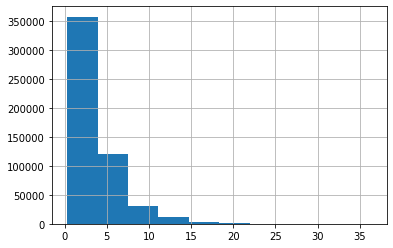

In [8]:
wind_speed = wr["HlyWindSpd (MPH)"]
wind_speed[wind_speed < 100].hist()

In [9]:
wind_speed.describe(percentiles=np.arange(0,1,.001)[-5:])

count    526692.000000
mean          3.823576
std           7.934127
min           0.300000
50%           2.900000
99.5%        17.500000
99.6%        18.300000
99.7%        19.300000
99.8%        20.600000
99.9%        22.700000
max        3704.700000
Name: HlyWindSpd (MPH), dtype: float64

### Start/End Dates for Dec-Jan PSPS Events

In [10]:
se_dates = source[["start", "end"]]
se_dates = se_dates[~se_dates.duplicated()].sort_values(by="start").reset_index(drop=True)
se_dates.iloc[6:]

,start,end
6,2020-12-04,2020-12-14
7,2020-12-16,2020-12-24
8,2021-01-12,2021-01-21


### Matching Notifications of PSPS Event by County against CIMIS Data

In [11]:
notifications = pd.read_csv("../data/2021/deenergization_2021.csv", parse_dates=True)
ws = pd.read_csv("../data/weather/weather_stations.csv", parse_dates=True)

notif_by_county = notifications.County.value_counts().sort_values()
notif_by_county = notif_by_county

counties = []
for county in notif_by_county.index:
     for c in county.split(";"):
            counties.append(c.title())

psps_county_stations = ws[ws.County.isin(counties)].StationNbr

len(set(counties)), len(psps_county_stations.values)

(9, 102)

In [12]:
wind_max = wr[wr.Station.isin(psps_county_stations.values)][["Station", "HlyWindSpd (MPH)"]].groupby("Station").max()
wind_max = wind_max[(wind_max > 25) & (wind_max < 60)].dropna()
wind_max

,HlyWindSpd (MPH)
Station,
125,30.6
197,29.5
204,28.0
234,26.1


In [13]:
ws[ws.StationNbr.isin(wind_max.index)]

,StationNbr,Name,City,RegionalOffice,County,ConnectDate,DisconnectDate,IsActive,IsEtoStation,Elevation,GroundCover,HmsLatitude,HmsLongitude,ZipCodes,SitingDesc
124,125,Arvin-Edison,Arvin,South Central Region Office,Kern,3/22/1995,12/31/2050,True,True,500,Grass,35º12'20N / 35.205583,-118º46'42W / -118.778410,['93203'],NaN
196,197,Palmdale,Palmdale,Southern Region Office,Los Angeles,4/6/2005,12/31/2050,True,True,2550,Grass,34º36'54N / 34.614981,-118º1'57W / -118.032490,"['93534', '93535', '93543', '93550', '93552', ...",NaN
203,204,Santa Clarita,Santa Clarita,Southern Region Office,Los Angeles,12/4/2006,12/31/2050,True,True,1410,Grass,34º25'35N / 34.426361,-118º31'3W / -118.517580,['91350'],NaN
233,234,Newberry Springs II,Newberry Springs,Southern Region Office,San Bernardino,2/25/2015,11/29/2020,True,True,1930,Grass,34º53'0N / 34.883472,-116º48'37W / -116.810247,"['92311', '92312', '92327', '92365', '92398']",NaN


### When do Wind Speed and Humidity achieve max/min values, respectively

In [14]:
crossings = wr[(wr["HlyWindSpd (MPH)"] > wr["HlyRelHum (%)"]) & (wr["HlyRelHum (%)"] > 0)]
crossings.head()

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
14825,2019-01-20,20,18:00:00,41,english,"92281, 92257, 92233",hourly,58.1,-36.9,0.00,...,NaN,0.0,1.0,2.7,45.2,1.0,0.2,132.0,2.8,2019-01-20 18:00:00
14834,2019-01-21,21,03:00:00,41,english,"92281, 92257, 92233",hourly,61.7,-8.9,0.00,...,NaN,0.0,5.0,7.1,45.0,0.0,1.0,263.0,8.3,2019-01-21 03:00:00
14835,2019-01-21,21,04:00:00,41,english,"92281, 92257, 92233",hourly,62.9,-26.7,0.01,...,NaN,0.0,2.0,9.6,44.8,0.0,0.4,265.0,11.4,2019-01-21 04:00:00
14847,2019-01-21,21,16:00:00,41,english,"92281, 92257, 92233",hourly,67.8,-5.1,0.01,...,NaN,0.0,5.0,13.2,45.7,537.0,1.2,294.0,13.6,2019-01-21 16:00:00
14854,2019-01-21,21,23:00:00,41,english,"92281, 92257, 92233",hourly,49.9,-36.9,0.00,...,NaN,0.0,2.0,2.1,46.3,0.0,0.2,276.0,2.9,2019-01-21 23:00:00


In [15]:
crossings.Date.value_counts().sort_index().loc["2021-01-17":"2021-01-20"]

2021-01-17     25
2021-01-18    115
2021-01-19    118
Name: Date, dtype: int64

In [16]:
station_crossings = crossings[(crossings.Date >= "2021-01-17") & (crossings.Date <= "2021-01-20")].Station.value_counts().sort_values(ascending=False)
station_crossings.head()

204    24
198    15
6      15
125    12
215    12
Name: Station, dtype: int64

In [17]:
station_crossings.index

Int64Index([204, 198,   6, 125, 215, 243, 139, 121, 217, 222, 152, 211, 247,
            140, 220, 262, 103,  88, 226, 221, 256, 212, 242, 206,  92,  91,
            129, 160, 144, 235, 248, 257, 187, 143, 254,  77, 116,  84,  70,
            228,  62, 224, 209, 253, 191],
           dtype='int64')

In [18]:
crossings[(crossings.Station == 44)].sort_values("Date").tail()

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
326174,2021-01-15,15,15:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.6,15.1,0.02,...,NaN,0.0,8.0,10.5,52.5,913.0,3.0,5.0,10.6,2021-01-15 15:00:00
326175,2021-01-15,15,16:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.2,14.1,0.01,...,NaN,0.0,7.0,7.7,52.9,560.0,2.9,7.0,8.0,2021-01-15 16:00:00
326198,2021-01-16,16,15:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,83.5,26.1,0.02,...,NaN,0.0,12.0,11.8,52.7,865.0,4.8,5.0,12.4,2021-01-16 15:00:00
326196,2021-01-16,16,13:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,82.3,25.5,0.02,...,NaN,0.0,12.0,13.8,51.9,1303.0,4.7,8.0,14.0,2021-01-16 13:00:00
326199,2021-01-16,16,16:00:00,44,english,"92522, 92521, 92519, 92518, 92517, 92516, 9251...",hourly,81.9,25.2,0.01,...,NaN,0.0,12.0,12.8,53.1,520.0,4.6,2.0,13.0,2021-01-16 16:00:00


### Visualizations by Station

In [59]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

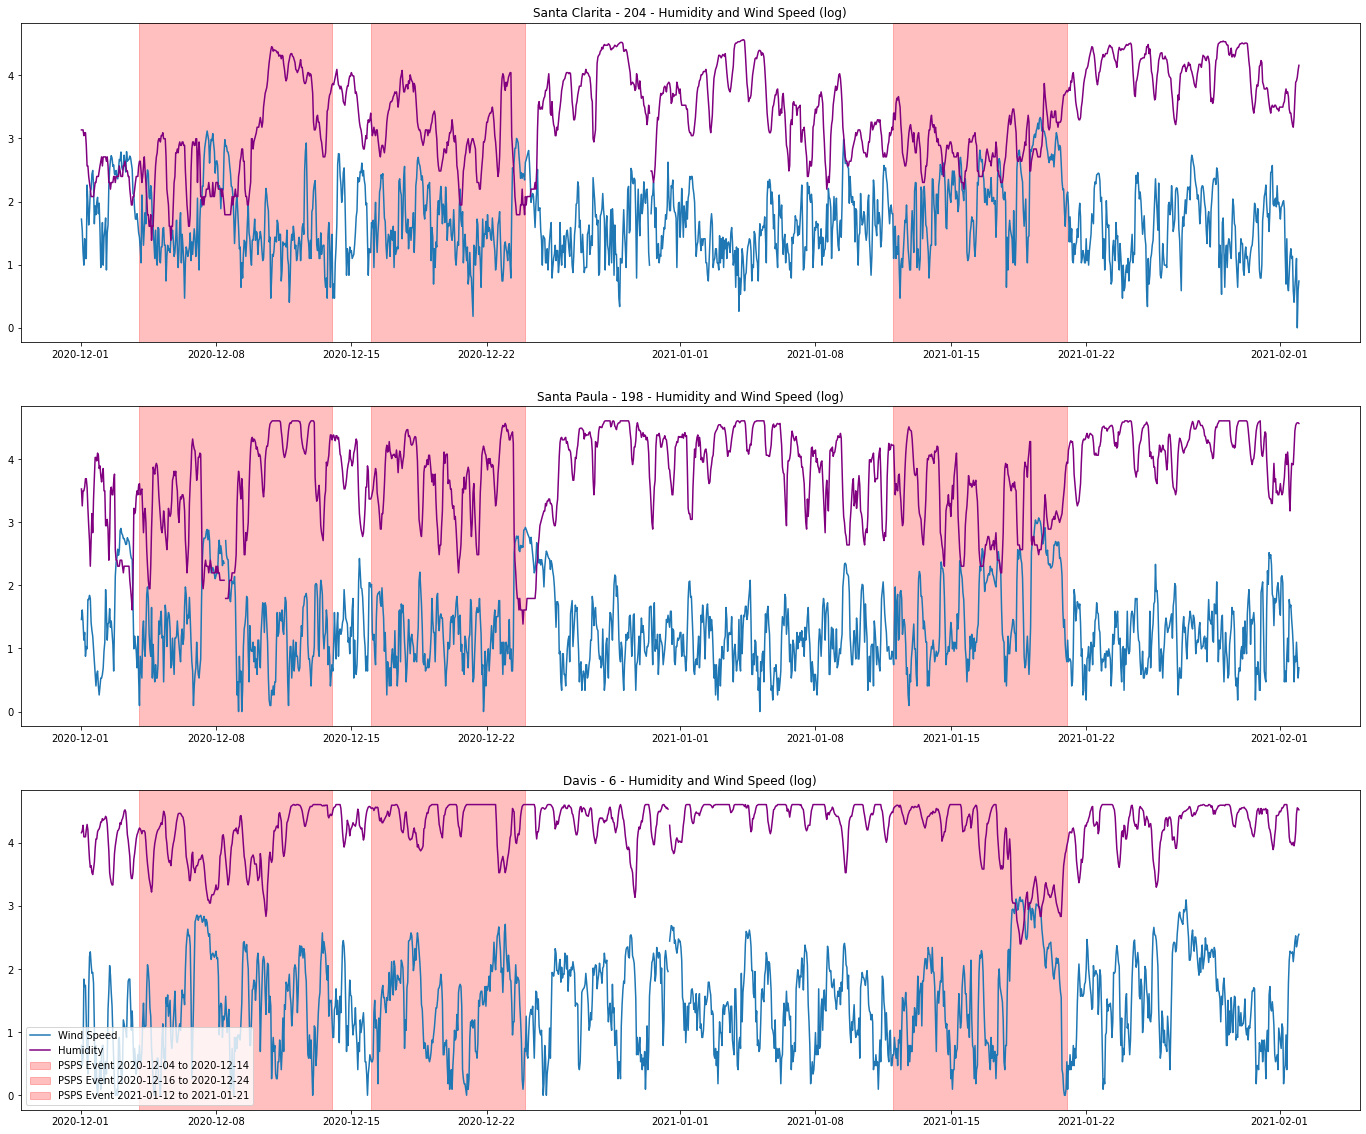

In [52]:
stations = station_crossings.head().index
dates = se_dates.iloc[6:]
fig, ax = plt.subplots(len(stations)-2, 1,figsize=(24,20), sharey=True)
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        if len(dates.index) == 2:
            wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="purple", label="Humidity")
        
        v_ax.set_title("{} - {} - Humidity and Wind Speed (log)".format(ws[ws.StationNbr == s].City.values[0],s))
        
        # For multiple date ranges, highlight relevant time
        if len(dates.index) > 2:
            for (start, end) in dates.values:
                v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))

#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

v_ax.legend(loc="lower left")
# plt.savefig("../images/wind_hum_log.png")


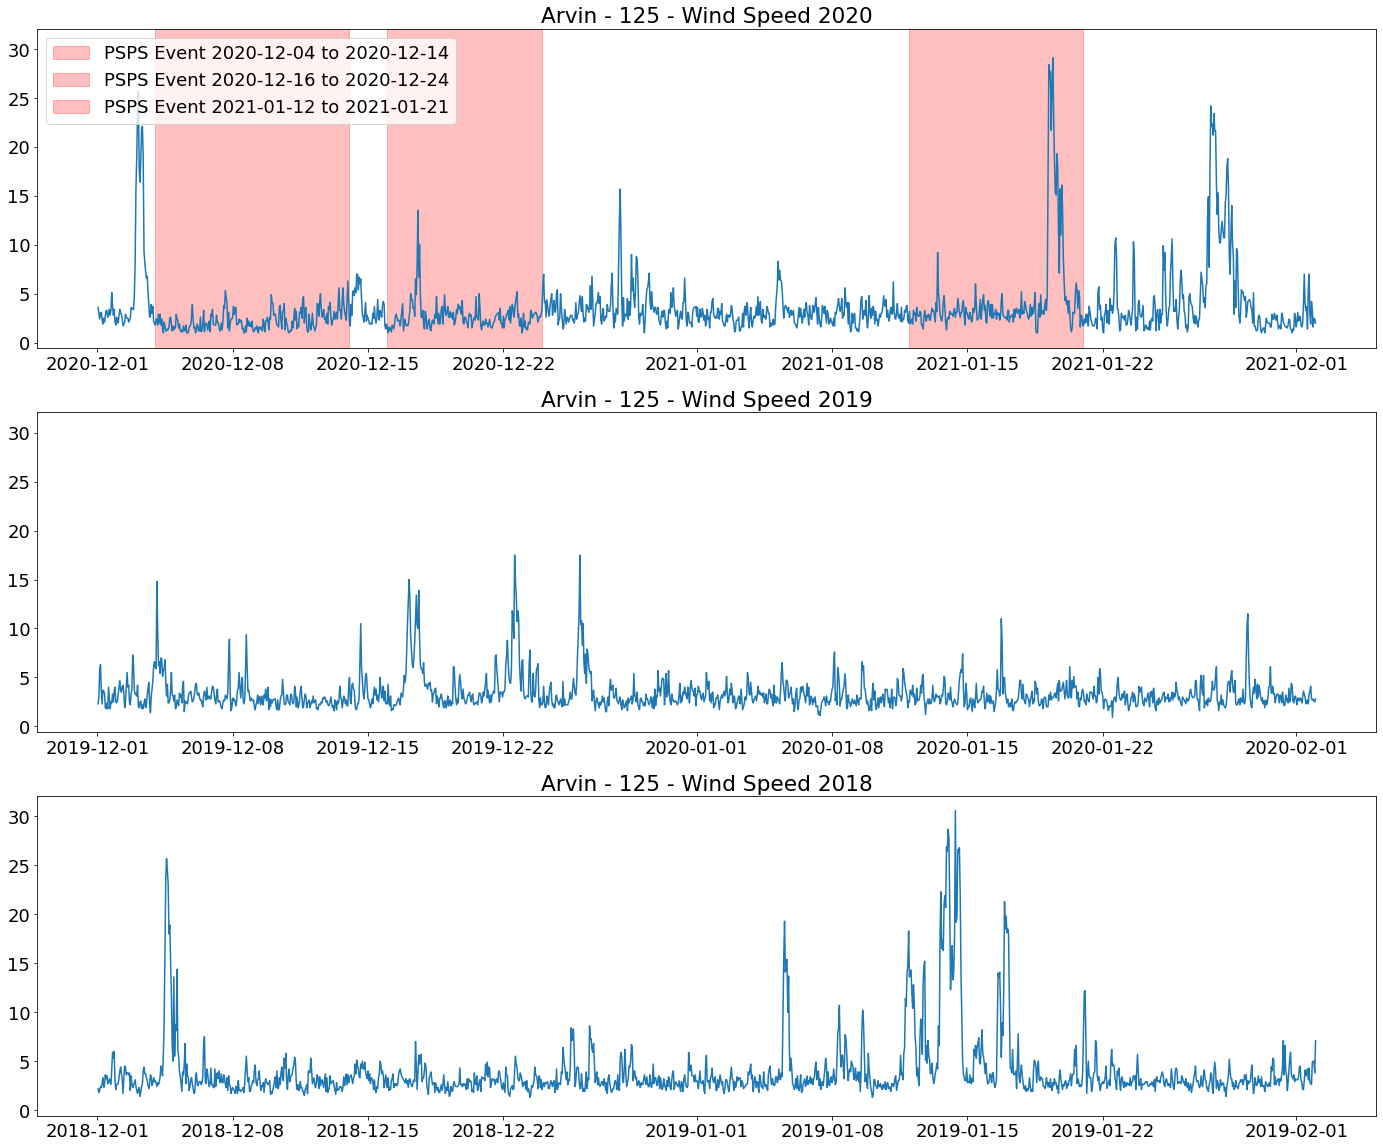

In [56]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
    start = pd.Timestamp("{}-12-01".format(year))
    end = start + two_months

    v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]))

#     v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="orange", label="Humidity")
    v_ax.set_title("{} - {} - Wind Speed {}".format(ws[ws.StationNbr == s].City.values[0],s, year))
    
    if year == "2020":
        for (start, end) in dates.values:
            v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))
            v_ax.legend(loc="upper left")
            
        
#     For multiple date ranges, highlight relevant time
#     v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

#     v_ax.legend(loc="upper left")
#     v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#     v_ax[1].set_title("{} Wind Speed Increments".format(s))

#     v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#     v_ax[3].set_title("{} Humidity".format(s))
plt.savefig("../images/historic_wind.png")


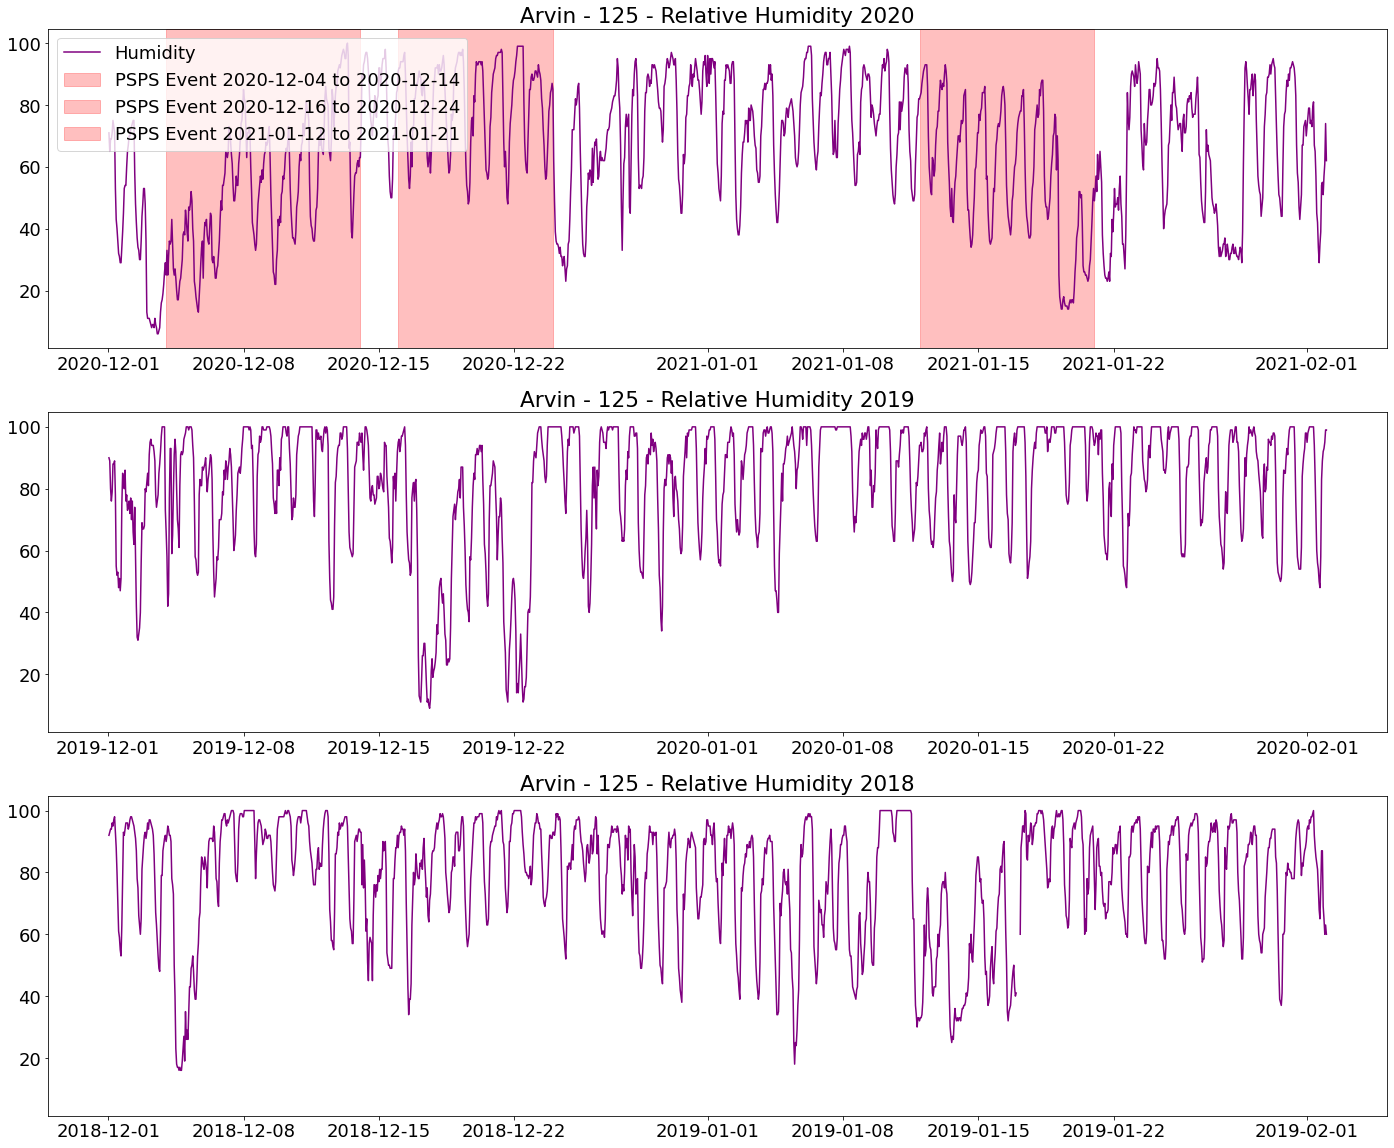

In [54]:
s = 125
wrs = wr[(wr.Station==s)].set_index("Time")

two_months = pd.Timedelta("62d")

fig, ax = plt.subplots(3, 1,figsize=(24,20), sharey=True)
for (year, v_ax) in zip(["2020", "2019", "2018"], ax): 
    start = pd.Timestamp("{}-12-01".format(year))
    end = start + two_months

#     v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyWindSpd (MPH)"]))

    v_ax.plot((wrs.loc[(wrs.Date >= start) & (wrs.Date <= end),"HlyRelHum (%)"]), color="purple", label="Humidity")
    v_ax.set_title("{} - {} - Relative Humidity {}".format(ws[ws.StationNbr == s].City.values[0],s, year))
    
    if year == "2020":
        for (start, end) in dates.values:
            v_ax.axvspan(start, end, color='red', alpha=0.25, label="PSPS Event {} to {}".format(pd.Timestamp(start).date(), pd.Timestamp(end).date()))
            v_ax.legend(loc="upper left")
            
        
#     For multiple date ranges, highlight relevant time
#     v_ax.axvspan("{}-12-01".format(year), "2021-01-21", color='red', alpha=0.25)

#     v_ax.legend(loc="upper left")
#     v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#     v_ax[1].set_title("{} Wind Speed Increments".format(s))

#     v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#     v_ax[3].set_title("{} Humidity".format(s))
plt.savefig("../images/historic_humidity.png")


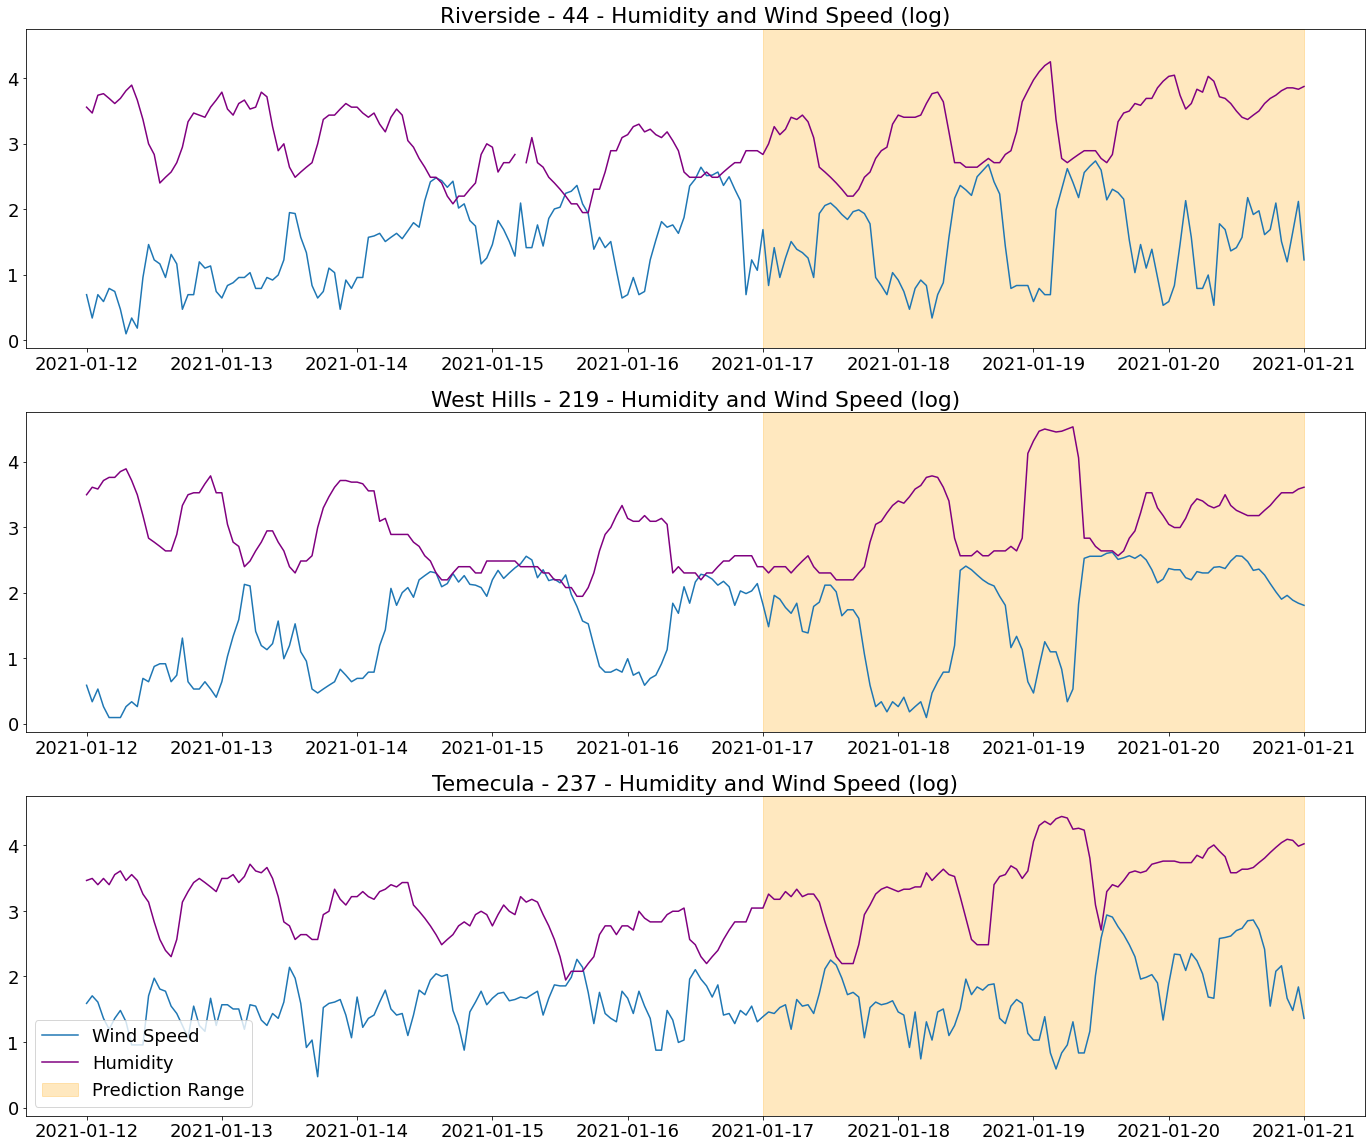

In [61]:
# 44, 219, 237
stations = [44, 219, 237]
dates = se_dates.iloc[8]
fig, ax = plt.subplots(len(stations), 1,figsize=(24,20), sharey=True)
for (s, v_ax) in zip(stations, ax):
        wrs = wr[(wr.Station==s) & (wr.Date >= "2020-12-01")]
        wrs.set_index("Time", inplace=True)
        
        # For a single date range, narrow plot to that range
        wrs = wrs.loc[dates.start:dates.end]
            
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]), label="Wind Speed")
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="purple", label="Humidity")
        
        v_ax.set_title("{} - {} - Humidity and Wind Speed (log)".format(ws[ws.StationNbr == s].City.values[0],s))
        
        # For multiple date ranges, highlight relevant time
        v_ax.axvspan("2021-01-17", end, color='orange', alpha=0.25, label="Prediction Range")

#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
            
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

v_ax.legend(loc="lower left")
plt.savefig("../images/near_crossings_log.png")



## GlutonTS

In [19]:
from gluonts.model.predictor import Predictor
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator

/usr/local/anaconda3/envs/gluon-ts/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [20]:
from gluonts.mx.distribution.gamma import GammaOutput
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.canonical import CanonicalRNNEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator # Not working?  NaN loss in most epochs
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.mx.trainer import Trainer

In [21]:
#(wr.Date.dt.year >= 2020) & (wr.Date.dt.month >= 12) & (wr.Station.isin(psps_county_stations.values))
wr_gts = wr.copy()
wr_gts.set_index("Time", inplace=True)
# wr_gts = wr_gts[wr_gts.columns[(wr_gts.columns.str.contains("Hly")) | (wr_gts.columns.str.contains("Station"))]]

In [22]:
target_columns = wr_gts.columns[wr_gts.columns.str.contains("Hly")]

keys = []
targets = []
for (key, df) in wr_gts.groupby(["Station", pd.Grouper(freq='1AS-DEC')]):
        tss = df[target_columns].transpose().iterrows()
        for (c, ts) in tss:
            targets.append(ts)
            keys.append((*key, c))

In [23]:
target_dict = {key:target for (key, target) in zip(keys, targets)}

In [24]:
# By default, take up to 3 days before event
training_data = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-17 00:00:00"]} for df in targets],
    freq = "60min"
)

training_data_3day = training_data

# 2018-2020 Jan only
training_data_year = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2020-02-01 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year < 2020],
    freq = "60min"
)

# Dec 2020 - Jan 2021 only
training_data_2020 = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-02-01 00:00:00"]} for (key, df) in zip(keys, targets) if key[1].year == 2020],
    freq = "60min"
)

# 1 week out from PSPS event
training_data_week = ListDataset(
    [{"start": df.index[0], "target": df.loc[:"2021-01-13 00:00:00"]} for df in targets],
    freq = "60min"
)

In [25]:
# Covers same range as the main training set, except 8 AM to 10 PM only
training_data_morn = ListDataset(
    [{"start": df.index[7], "target": df.loc[(df.index.hour >= 8) & (df.index.hour <= 22) & (df.index <= "2021-01-17 00:00:00")]} for df in targets],
    freq = "60min"
)

### Model Parameters
- model = Deep AR Estimator
- all   = 2018-2021 Dec-Jan Data
- year  = 2018, 2019 Dec-Jan Data only
- d     = days, 7d models are trained from the 17th (8L) and 13th (10L) respectively
- e     = epochs
- L     = Layers
- CL    = Context Length (default = prediction_length)

### Models
- model-all-e100-4L
- model-all-e100-10L
- model-all-e100-20L
- model-year-e100-20L:  Trained on 2018 - Feb 2020 data only
- model-all-e100-10L-7d:  Trained until Jan 13th

In [60]:
estimator = DeepAREstimator(freq="1H", prediction_length=24*3, trainer=Trainer(epochs=100, batch_size=32), num_layers=20)
# estimator = DeepFactorEstimator(freq="60min", prediction_length=24*3, trainer=Trainer(epochs=100, learning_rate=.00001))

### Train a new model...

In [61]:
predictor = estimator.train(training_data=training_data_2020)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [01:20<00:00,  1.62s/it, epoch=100/100, avg_epoch_loss=0.327]


In [62]:
predictor.serialize(Path("../models/model-2020-e100-20L-1HR"))

### ...or load an existing one!

In [26]:
list(filter(lambda s: s.startswith("model"), os.listdir("../models")))

['model-all-e100-20L-morn',
 'model-all-e100-8L-7d',
 'model-all-e100-10L-7d',
 'model-all-e100-10L',
 'model-all-e100-20L-1HR',
 'model-year-e100-20L',
 'model-all-e100-4L',
 'model-2020-e100-20L-1HR',
 'model-all-e100-20L']

In [27]:
predictor = Predictor.deserialize(Path("../models/model-all-e100-20L-1HR"))

### Visualize Predictions

In [37]:
test_station = 44
wr_test = wr_gts[(wr_gts.Station==test_station) & (wr_gts.Date.dt.year==2021)]
# wr_test.set_index("Time", inplace=True)
wr_test = wr_test[target_columns]

test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

test_data_3day = test_data

test_data_week = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

# Covers same range as the main training set, except 8 AM to 10 PM only
test_data_morn = ListDataset(
    [{"start": wr_test.index[7], "target": wr_test.loc[(wr_test.index.hour >= 8) & (wr_test.index.hour <= 22) & (wr_test.index <= "2021-01-20 00:00:00"), c]} for c in target_columns],
    freq = "60min"
)

test_data_null = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-02-01 00:00:00", c]} for c in target_columns],
    freq = "60min"
)

In [39]:
sforecast_it, sts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=200,  # number of sample paths we want for evaluation
)

In [40]:
sforecasts = list(sforecast_it)
stss = list(sts_it)

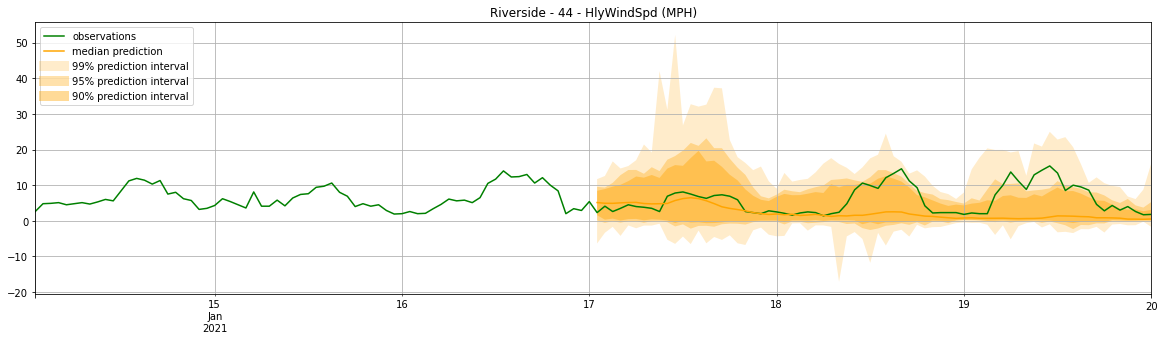

In [41]:
plot_length = 2*3*24
prediction_intervals = [90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))

# Humidity
# i = 7
# stss[i][-plot_length:].plot(ax=ax, color="red")  # plot the time series
# sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

# # Wind
i = 13
stss[i][-plot_length:].plot(ax=ax, color="green")  # plot the time series
sforecasts[i].plot(prediction_intervals=prediction_intervals, color='orange')

#ax.set_xbound("2021-01-17", "2021-01-19")
# ax.set_ybound(20,100)
plt.title("{} - {} - {}".format(ws[ws.StationNbr == test_station].City.values[0], test_station, target_columns[i]))
plt.grid(which="both")
plt.legend(legend, loc="upper left")
# plt.savefig("../images/all/125_temp_3day.png")
plt.show()

### Compute metrics

In [139]:
# metrics = []
# for s in psps_county_stations.values:
#     wr_test = wr_gts[(wr_gts.Station==s) & (wr_gts.Date.dt.year==2021)]
#     wr_test = wr_test[target_columns]
    
#     if len(wr_test.index) == 0:
#         continue
    
#     metric = {}
#     metric["station"] = s

#     test_data = ListDataset(
#         [{"start": wr_test.index[0], "target": wr_test.loc[:"2021-01-20 00:00:00", c]} for c in target_columns],
#         freq = "60min"
#     )

#     forecast_it, ts_it = make_evaluation_predictions(
#         dataset=test_data,  # test dataset
#         predictor=predictor,  # predictor
#         num_samples=100,  # number of sample paths we want for evaluation
#     )
    
#     forecasts = list(forecast_it)
#     tss = list(ts_it)
    
#     for i in range(14):
#         metric[target_columns[i]] = sum(tss[i][-int(plot_length/2):].values.reshape(-1) < forecasts[i].quantile(.99))/(plot_length/2)
        
#     metrics.append(metric)


- Metrics computed from 500 samples for 3-day model, 100 samples for 7-day model

In [28]:
test_keys = [key for key in keys if key[1].year == 2020 and key[2] in target_columns[[0,7,13]]]
all_test_data = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-20 00:00:00"]} for key in test_keys],
    freq = "60min"
)

all_test_data_3day = all_test_data

all_test_data_week = ListDataset(
    [{"start": target_dict[key].index[0], "target": target_dict[key].loc[:"2021-01-20 00:00:00"]} for key in test_keys],
    freq = "60min"
)

In [29]:
# Covers same range as the main test set, except 8 AM to 10 PM only
test_data_morn = ListDataset(
    [{"start": df.index[7], "target": df.loc[(df.index.hour >= 8) & (df.index.hour <= 22) & (df.index <= "2021-01-20 00:00:00")]} for df in targets],
    freq = "60min"
)

In [30]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=200,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_all_it)
tss = list(ts_all_it)

In [31]:
print(len(forecasts), len(tss), len(test_keys))

453 453 453


#### Metric Computations:  % with 99th Percentile

plot_length=2*3*24
metrics = defaultdict(dict)
for (k, f, ts) in zip(test_keys, forecasts, tss):
    metrics[k[0]][k[2]] = sum(ts[-int(plot_length/2):].values.reshape(-1) < f.quantile(.99))/(plot_length/2)

In [45]:
metricsdf = pd.DataFrame(metrics).transpose().sort_index()
metricsdf.head()

,HlyAirTmp (F),HlyRelHum (%),HlyWindSpd (MPH)
2,1.000,1.000000,0.861111
5,1.000,0.986111,0.986111
6,1.000,1.000000,0.458333
7,1.000,1.000000,0.972222
12,0.875,1.000000,0.736111


In [42]:
metricsdf.mean()

HlyAirTmp (F)       0.925957
HlyRelHum (%)       0.954010
HlyWindSpd (MPH)    0.839864
dtype: float64

In [43]:
metricsdf.to_csv("../data/metrics/metrics_2020_e100_20L_1H.csv")

#### Metric Computations:  Crossings

In [76]:
wr_gts.loc[(wr_gts.Station == 234) & (wr_gts.index >= "2021-01-12"), ["Station", "HlyWindSpd (MPH)", "HlyRelHum (%)"]].isna()

,Station,HlyWindSpd (MPH),HlyRelHum (%)
Time,,,
2021-01-12 00:00:00,False,True,True
2021-01-12 01:00:00,False,True,True
2021-01-12 02:00:00,False,True,True
2021-01-12 03:00:00,False,True,True
2021-01-12 04:00:00,False,True,True
...,...,...,...
2021-02-01 20:00:00,False,True,True
2021-02-01 21:00:00,False,True,True
2021-02-01 22:00:00,False,True,True


In [32]:
crossings_forecast = {}
for i in range(int(len(test_keys)/3)):
    crossings_forecast[test_keys[3*i][0]] = (forecasts[3*i+1].samples < forecasts[3*i+2].samples).any(axis=1).mean()
crossings_forecast_series = pd.Series(crossings_forecast)

In [33]:
crossings_forecast_series.sort_values().describe(percentiles=np.arange(0,1,.1))

count    151.000000
mean       0.226656
std        0.266027
min        0.000000
0%         0.000000
10%        0.040000
20%        0.055000
30%        0.065000
40%        0.080000
50%        0.110000
60%        0.135000
70%        0.230000
80%        0.360000
90%        0.685000
max        1.000000
dtype: float64

In [34]:
crossings_forecast_df = pd.DataFrame([crossings_forecast_series, station_crossings]).transpose()
crossings_forecast_df.columns = ["Prob of Crossing", "Actual Crossing Count"]
crossings_forecast_df.fillna(0, inplace=True)

In [36]:
crossings_forecast_df[crossings_forecast_df["Prob of Crossing"] > .5].sort_values("Prob of Crossing")

,Prob of Crossing,Actual Crossing Count
184,0.505,0.0
135,0.575,0.0
47,0.655,0.0
75,0.670,0.0
216,0.675,0.0
99,0.685,0.0
240,0.695,0.0
245,0.730,0.0
258,0.745,0.0
91,0.745,4.0


In [307]:
crossings_forecast_df.iloc[44]

Prob of Crossing          0.06
Actual Crossing Count    10.00
Name: 121, dtype: float64

In [83]:
crossings_forecast_df.to_csv("../data/metrics/summaries/crossings.csv")

#### Metric Analysis

In [46]:
metrics_dict = {}
for s in os.listdir("../data/metrics"):
    if s.endswith(".csv"):
        metrics_dict[s[:-4]] = pd.read_csv("../data/metrics/" + s).mean(axis=0)
metrics_dict.keys()

dict_keys(['metrics_all_4L', 'metrics_all_e100_10L_7d', 'metrics_all_e100_20L_1H', 'metrics_all', 'metrics_all_10L', 'metrics_year', 'gluon_metrics'])

In [331]:
all_metrics = pd.DataFrame(metrics_dict)
all_metrics.drop("Unnamed: 0", axis=0, inplace=True)
all_metrics[all_metrics.columns.sort_values(ascending=True)]

,metrics_all,metrics_all_10L,metrics_all_4L,metrics_all_e100_10L_7d,metrics_year
HlyAirTmp (F),0.968175,0.912160,0.942329,0.954864,0.959069
HlyRelHum (%),0.974062,0.939478,0.888337,0.969095,0.976729
HlyWindSpd (MPH),0.925497,0.892476,0.651950,0.903658,0.834437


- What is the floating precision of the model parameters?  8?  32?
- How about 10 layers?
- What about minimum thresholds, cutting off low wind values?  Exclude evening values, train on day's values

In [168]:
metricsdf_new = pd.read_csv("../data/metrics/metrics_all_new.csv").set_index("Unnamed: 0")
metricsdf_new.loc[204]

HlyAirTmp (F)       1.000000
HlyRelHum (%)       1.000000
HlyWindSpd (MPH)    0.916667
Name: 204, dtype: float64

### Gluon-ts Metrics

In [77]:
models_eval = list(filter(lambda s: s.startswith("model") and "morn" not in s and "7d" not in s, os.listdir("../models")))
models_eval

['model-all-e100-10L',
 'model-all-e100-20L-1HR',
 'model-year-e100-20L',
 'model-all-e100-4L',
 'model-2020-e100-20L-1HR',
 'model-all-e100-20L']

In [63]:
pred_eval = Predictor.deserialize(Path("../models/model-year-e100-20L"))

In [47]:
forecast_all_it, ts_all_it = make_evaluation_predictions(
    dataset=all_test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
# forecasts = list(forecast_all_it)
# tss = list(ts_all_it)

In [48]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(ts_all_it, forecast_all_it, num_series=len(all_test_data))

Running evaluation: 100%|██████████| 453/453 [04:37<00:00,  1.63it/s]
/usr/local/anaconda3/envs/gluon-ts/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1516: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


In [49]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 523.469661914426,
    "abs_error": 368048.32482147217,
    "abs_target_sum": 1142880.8021697998,
    "abs_target_mean": 35.64187502791929,
    "seasonal_error": 6.274190877715173,
    "MASE": 1.9464897791512807,
    "MAPE": 0.5432224917850511,
    "sMAPE": 0.4687407510234675,
    "OWA": NaN,
    "MSIS": 22.564475243399784,
    "QuantileLoss[0.1]": 277871.4444145858,
    "Coverage[0.1]": 0.1622997638396963,
    "QuantileLoss[0.5]": 368048.32458385825,
    "Coverage[0.5]": 0.4042168878063169,
    "QuantileLoss[0.9]": 203514.82397024627,
    "Coverage[0.9]": 0.7476672173710248,
    "QuantileLoss[0.95]": 145055.96358801133,
    "Coverage[0.95]": 0.8226770528921136,
    "QuantileLoss[0.99]": 56880.658825556064,
    "Coverage[0.99]": 0.9199954876383868,
    "RMSE": 22.87945938859627,
    "NRMSE": 0.6419263680901788,
    "ND": 0.3220356174700978,
    "wQuantileLoss[0.1]": 0.24313248055880982,
    "wQuantileLoss[0.5]": 0.32203561726218993,
    "wQuantileLoss[0.9]": 0.1780717845499

In [78]:
pred_metrics = {}
evaluator = Evaluator(quantiles=[0.5, 0.75, 0.99])

In [79]:
for m in models_eval:
    print("Evaluating:  ", m)
    pred_eval = Predictor.deserialize(Path("../models/" + m))
    
    forecast_eval, ts_eval = make_evaluation_predictions(
        dataset=all_test_data,  # test dataset
        predictor=pred_eval,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    
    agg_metrics, item_metrics = evaluator(ts_eval, forecast_eval, num_series=len(all_test_data))
    
    pred_metrics[m] = agg_metrics

Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-10L


Running evaluation: 100%|██████████| 453/453 [02:16<00:00,  3.32it/s]
/usr/local/anaconda3/envs/gluon-ts/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1516: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)
Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-20L-1HR


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-year-e100-20L


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-4L


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-2020-e100-20L-1HR


Running evaluation:   0%|          | 0/453 [00:00<?, ?it/s]

Evaluating:   model-all-e100-20L


Running evaluation: 100%|██████████| 453/453 [04:36<00:00,  1.64it/s]


In [80]:
gluon_metrics_df = pd.DataFrame(pred_metrics)
gluon_metrics_df

,model-all-e100-10L,model-all-e100-20L-1HR,model-year-e100-20L,model-all-e100-4L,model-2020-e100-20L-1HR,model-all-e100-20L
MSE,4.090408e+02,5.212673e+02,4.455226e+02,3.637841e+02,3.408710e+03,4.575544e+02
abs_error,3.532406e+05,3.681334e+05,3.680518e+05,4.528045e+05,1.095240e+06,3.712727e+05
abs_target_sum,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06
abs_target_mean,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01
seasonal_error,2.360803e+00,6.274191e+00,2.360803e+00,2.360803e+00,6.274191e+00,2.360803e+00
MASE,4.487001e+00,1.945889e+00,4.609849e+00,6.133572e+00,5.376023e+00,4.582029e+00
MAPE,5.120254e-01,5.453917e-01,5.227245e-01,4.598822e-01,1.194702e+00,5.239230e-01
sMAPE,4.339599e-01,4.684550e-01,4.375678e-01,5.109209e-01,5.885626e-01,4.217320e-01
OWA,NaN,NaN,NaN,NaN,NaN,NaN
MSIS,5.932696e+01,2.301594e+01,6.027836e+01,7.005593e+01,3.187385e+01,5.569598e+01


In [81]:
gluon_metrics_df.columns

Index(['model-all-e100-10L', 'model-all-e100-20L-1HR', 'model-year-e100-20L',
       'model-all-e100-4L', 'model-2020-e100-20L-1HR', 'model-all-e100-20L'],
      dtype='object')

In [74]:
model_order = ['model-all-e100-4L', 'model-all-e100-10L' , 'model-all-e100-20L', 'model-year-e100-20L', 'model-all-e100-20L-morn']
gluon_metrics_df[model_order]

,model-all-e100-4L,model-all-e100-10L,model-all-e100-20L,model-year-e100-20L,model-all-e100-20L-morn
MSE,3.617048e+02,4.122161e+02,4.619693e+02,4.403877e+02,5.651287e+02
abs_error,4.521496e+05,3.534724e+05,3.716892e+05,3.667884e+05,4.395308e+05
abs_target_sum,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06,1.142881e+06
abs_target_mean,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01,3.564188e+01
seasonal_error,2.360803e+00,2.360803e+00,2.360803e+00,2.360803e+00,2.360803e+00
MASE,6.130031e+00,4.491303e+00,4.590389e+00,4.604018e+00,5.278972e+00
MAPE,4.612168e-01,5.111790e-01,5.254450e-01,5.199554e-01,6.131353e-01
sMAPE,5.109093e-01,4.339274e-01,4.228703e-01,4.368863e-01,4.512471e-01
OWA,NaN,NaN,NaN,NaN,NaN
MSIS,7.026964e+01,6.032109e+01,5.560632e+01,5.906018e+01,7.081799e+01


In [82]:
gluon_metrics_df.dropna().to_csv("../data/metrics/gluon_metrics_latest.csv")